In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt, SimpleExpSmoothing, ExponentialSmoothing 
import warnings
warnings.filterwarnings("ignore") 

In [2]:
cola=pd.read_excel("/CocaCola_Sales.xlsx")
cola.tail()

,Quarter,Sales
37,Q2_95,4936.0
38,Q3_95,4895.0
39,Q4_95,4333.0
40,Q1_96,4194.0
41,Q2_96,5253.0


In [3]:
coca = cola["Quarter"].str.split("_", n = 1, expand = True)
cola["quarter"]= coca[0]
cola["year"]= coca[1]
cola.drop(columns =["Quarter"], inplace = True)
cola.head()

,Sales,quarter,year
0,1734.827000,Q1,86
1,2244.960999,Q2,86
2,2533.804993,Q3,86
3,2154.962997,Q4,86
4,1547.818996,Q1,87


In [4]:
cola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Sales    42 non-null     float64
 1   quarter  42 non-null     object 
 2   year     42 non-null     object 
dtypes: float64(1), object(2)
memory usage: 1.1+ KB


In [5]:
cola.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


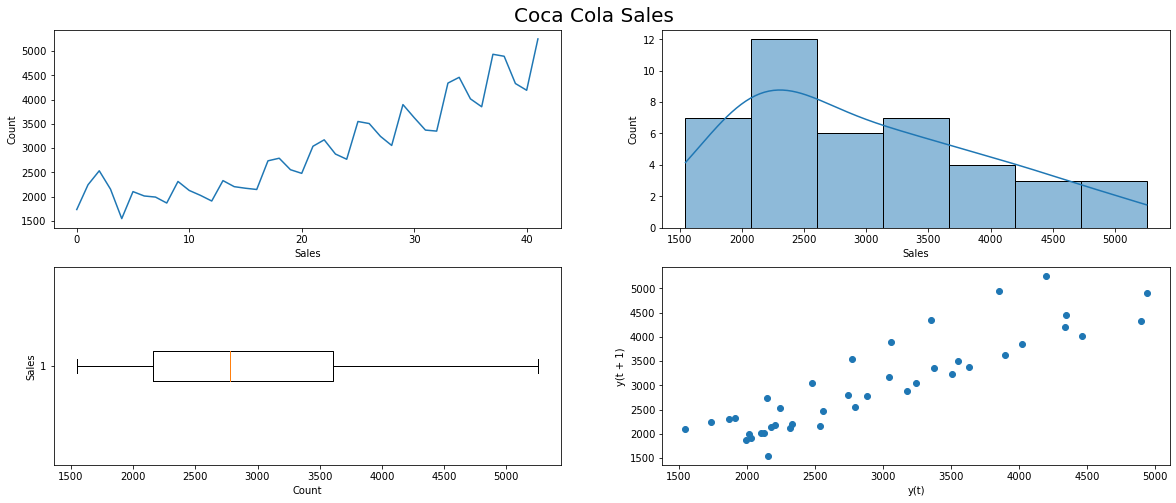

In [6]:
fig = plt.figure(figsize=(20,8))
plt.suptitle("Coca Cola Sales", size=20, y=.92) 

plt.subplot(2,2,1)
cola.Sales.plot()
plt.xlabel("Sales")
plt.ylabel("Count")

plt.subplot(2,2,2)
sns.histplot(x="Sales",data=cola,kde=True)

plt.subplot(2,2,3)
plt.boxplot(cola["Sales"],vert = False)
plt.xlabel("Count")
plt.ylabel("Sales")

plt.subplot(2,2,4)
lag_plot(cola.Sales)
plt.show();

*The Line Plot shows upward linear trend with Multiplicative seasonality.             
The Histogram is Positive Skew with a tapering tail towards right.          
The Box Plot also shows a vast distance between the Whisker and Upper-Quartile.            
The Lag Plot shows a Linear Relationship between the y(t) & y(t+1).*

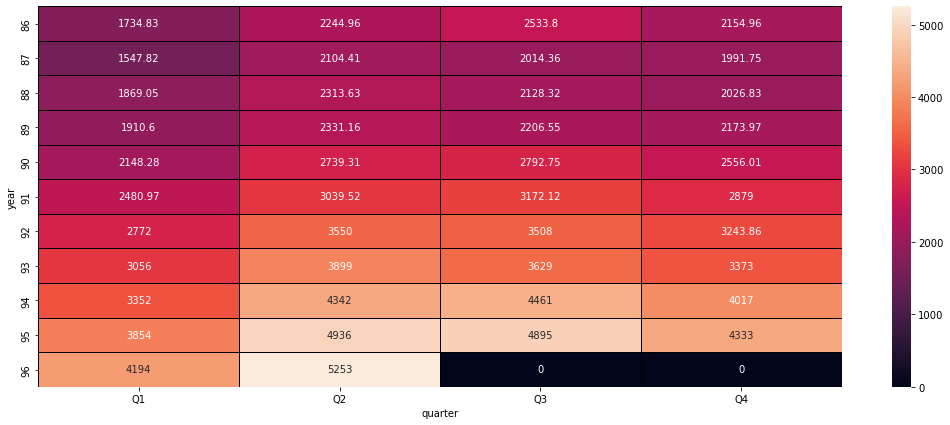

In [7]:
#Heatmap of average passengers month and year wise
plt.figure(figsize=(18,7))
heatmap_y_month = pd.pivot_table(data = cola,values="Sales",index="year",columns="quarter",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g",linewidths=.5,linecolor="black");

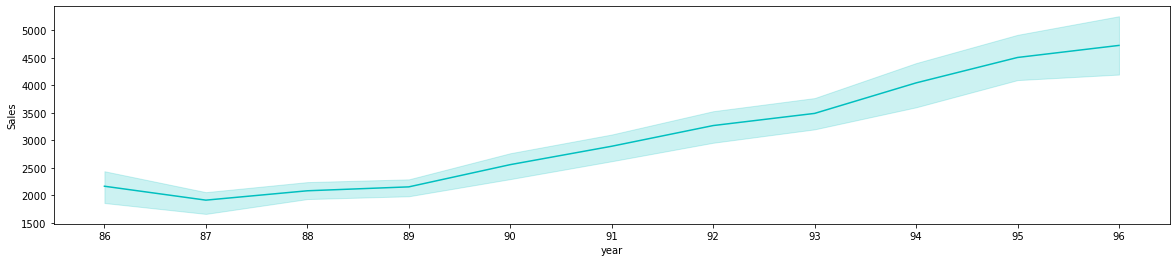

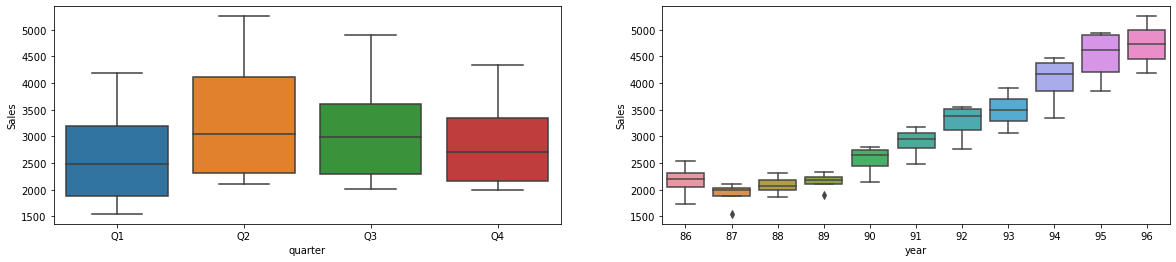

In [8]:
plt.figure(figsize=(20,4))
sns.lineplot(x="year",y="Sales",data=cola,color="c")

plt.figure(figsize=(20,4))
plt.subplot(121)
sns.boxplot(x="quarter",y="Sales",data=cola)
plt.subplot(122)
sns.boxplot(x="year",y="Sales",data=cola);

*It can be seen that Coca Cola Sales is increasing year by year*        
**Data Preprocessing**

In [9]:
quarter_dummies = pd.DataFrame(pd.get_dummies(cola["quarter"]))
cola1 = pd.concat([cola,quarter_dummies],axis=1)
cola1["t"] = np.arange(1,43)
cola1["t_square"] = cola1["t"]**2
cola1["log"] = np.log(cola1.Sales)
cola1.head()

,Sales,quarter,year,Q1,Q2,Q3,Q4,t,t_square,log
0,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


In [10]:
#Splitting data
Train = cola1.head(30)
Test = cola1.tail(12)

**Testing various model with accuracy**                        
## Model-Based Methods

In [11]:
#Linear Model
linear_model = smf.ols("Sales~t",data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test["t"])))
rmse_linear = np.sqrt(np.mean((np.array(Test["Sales"])-np.array(pred_linear))**2))

In [12]:
#Exponential
Exp = smf.ols("log~t",data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test["t"])))
rmse_Exp = np.sqrt(np.mean((np.array(Test["Sales"])-np.array(np.exp(pred_Exp)))**2))

In [13]:
#Quadratic 
Quad = smf.ols("Sales~t+t_square",data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test["Sales"])-np.array(pred_Quad))**2))

In [14]:
#Additive seasonality 
add_sea = smf.ols("Sales~Q1+Q2+Q3+Q4",data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[["Q1","Q2","Q3","Q4"]]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test["Sales"])-np.array(pred_add_sea))**2))

In [15]:
#Additive Seasonality Quadratic 
add_sea_Quad = smf.ols("Sales~t+t_square+Q1+Q2+Q3+Q4",data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[["Q1","Q2","Q3","Q4","t","t_square"]]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test["Sales"])-np.array(pred_add_sea_quad))**2))

In [16]:
#Multiplicative Seasonality
Mul_sea = smf.ols("log~Q1+Q2+Q3+Q4",data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test["Sales"])-np.array(np.exp(pred_Mult_sea)))**2))

In [17]:
#Multiplicative Additive Seasonality 
Mul_Add_sea = smf.ols("log~t+Q1+Q2+Q3+Q4",data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test["Sales"])-np.array(np.exp(pred_Mult_add_sea)))**2))

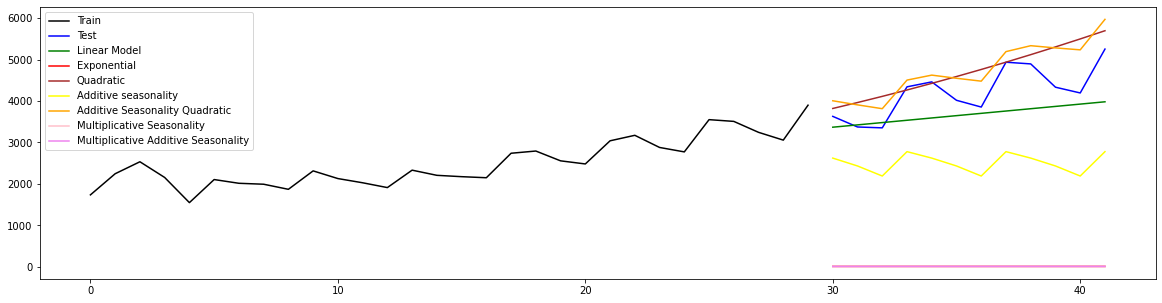

In [18]:
plt.figure(figsize=(20,5))
plt.plot(Train.index, Train["Sales"], label="Train",color="black")
plt.plot(Test.index, Test["Sales"], label="Test",color="blue")
plt.plot(pred_linear.index, pred_linear, label="Linear Model",color="green")
plt.plot(pred_Exp.index, pred_Exp, label="Exponential",color="red")
plt.plot(pred_Quad.index,pred_Quad,label="Quadratic",color="brown")
plt.plot(pred_add_sea.index,pred_add_sea,label="Additive seasonality",color="yellow")
plt.plot(pred_add_sea_quad.index,pred_add_sea_quad,label="Additive Seasonality Quadratic",color="orange")
plt.plot(pred_Mult_sea.index,pred_Mult_sea,label="Multiplicative Seasonality",color="pink")
plt.plot(pred_Mult_add_sea.index,pred_Mult_add_sea,label="Multiplicative Additive Seasonality",color="violet")
plt.legend(loc="best");

In [19]:
#Compare the results 
data={"Model_Based":pd.Series(["Linear","Exponential","Quadratic","Additive seasonality","Additive Seasonality Quadratic",
                         "Multiplicative Seasonality","Multiplicative Additive Seasonality"]),
      "RMSE Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
m_table_rmse=pd.DataFrame(data,index=None)
m_table_rmse.sort_values(['RMSE Values'])

,Model_Based,RMSE Values
6,Multiplicative Additive Seasonality,410.249706
1,Exponential,552.282104
4,Additive Seasonality Quadratic,586.053307
2,Quadratic,646.271543
0,Linear,714.014448
3,Additive seasonality,1778.006547
5,Multiplicative Seasonality,1828.923891


*Multiplicative Additive Seasonality with the lowest RMSE Value of 410.249706 is preferable*                          
## Data-Driven Models

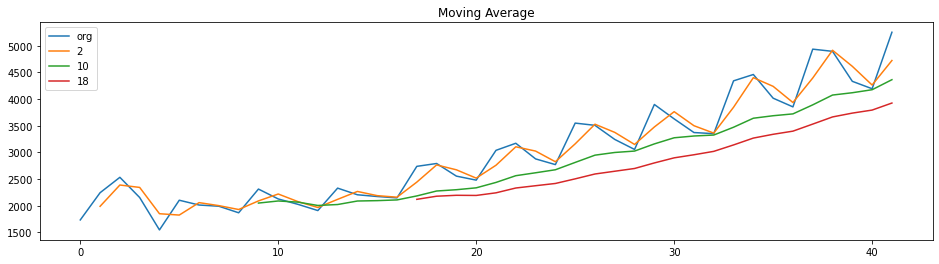

In [20]:
plt.figure(figsize=(16,4))
cola1.Sales.plot(label="org")
for i in range(2,24,8):  # for range 2-24 with intervals of 8
    cola1["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc="best")
plt.title("Moving Average");

**Time series decomposition plot**

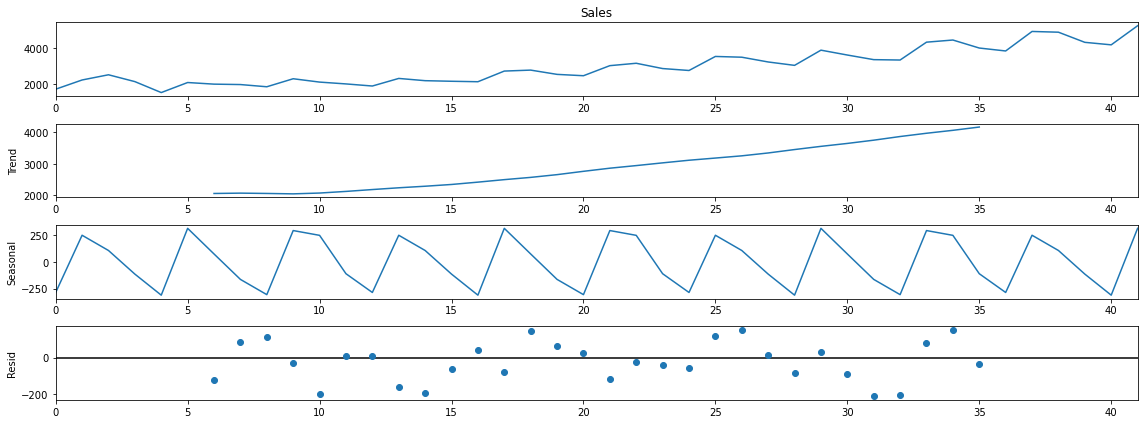

In [21]:
decompose_ts_add = seasonal_decompose(cola1.Sales,period=12)
fig=decompose_ts_add.plot()
fig.set_size_inches((16, 6))
fig.tight_layout()
plt.show();

**ACF plots and PACF plots**

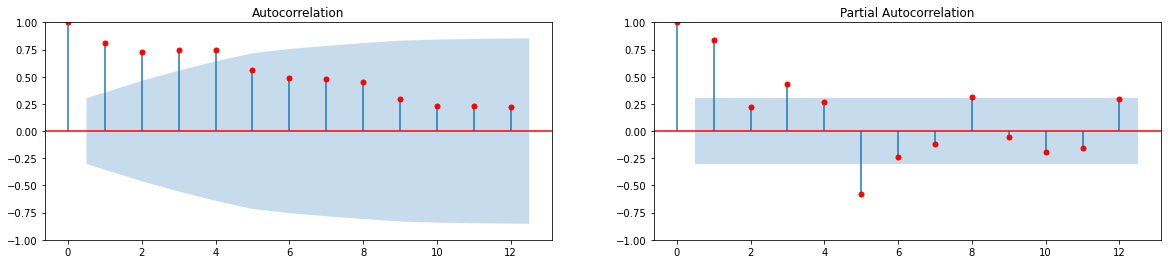

In [22]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches((20, 4))
tsa_plots.plot_acf(cola1.Sales,lags=12,color="red", ax=ax[0])
tsa_plots.plot_pacf(cola1.Sales,lags=12,color="red", ax=ax[1]);

*Starting few points seems to be statistically significant*

In [23]:
#Evaluation Metric MAPE
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [24]:
#Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses = np.sqrt(np.mean((np.array(Test["Sales"])-np.array((pred_ses)))**2))
mape_ses = MAPE(pred_ses,Test.Sales) 

In [25]:
#Holt method
hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw = np.sqrt(np.mean((np.array(Test["Sales"])-np.array((pred_hw)))**2))
mape_hw = MAPE(pred_hw,Test.Sales) 

In [26]:
#Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() 
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_aa = np.sqrt(np.mean((np.array(Test["Sales"])-np.array((pred_hwe_add_add)))**2))
mape_hwe_aa = MAPE(pred_hwe_add_add,Test.Sales) 

In [27]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_ma = np.sqrt(np.mean((np.array(Test["Sales"])-np.array((pred_hwe_mul_add)))**2))
mape_hwe_ma = MAPE(pred_hwe_mul_add,Test.Sales)

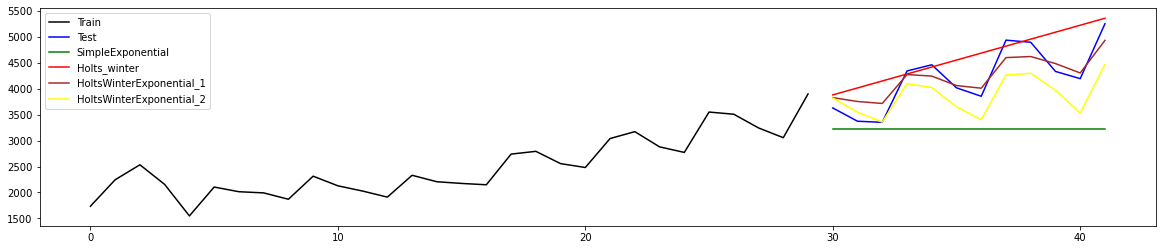

In [28]:
plt.figure(figsize=(20,4))
plt.plot(Train.index, Train["Sales"], label="Train",color="black")
plt.plot(Test.index, Test["Sales"], label="Test",color="blue")
plt.plot(pred_ses.index, pred_ses, label="SimpleExponential",color="green")
plt.plot(pred_hw.index, pred_hw, label="Holts_winter",color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.legend(loc="best");

In [29]:
#Compare the results 
data={"Data_Driven":pd.Series(["Simple Exponential Method","Holt method","Winter with additive seasonality and trend",
                              "Winter with multiplicative seasonality and additive trend"]),
      "RMSE Values":pd.Series([rmse_ses,rmse_hw,rmse_hwe_aa,rmse_hwe_ma]),
     "MAPE Values":pd.Series([mape_ses,mape_hw,mape_hwe_aa,mape_hwe_ma])}
dd_table_rmse=pd.DataFrame(data,index=None)
dd_table_rmse.sort_values(['RMSE Values'])

,Data_Driven,RMSE Values,MAPE Values
2,Winter with additive seasonality and trend,245.247579,5.321406
3,Winter with multiplicative seasonality and add...,470.621743,9.329400
1,Holt method,559.520106,11.213842
0,Simple Exponential Method,1153.703171,22.046764


*Holts winter exponential smoothing with additive seasonality and  trend with the lowest RMSE Value of 245.247579 is preferable* 
## ARIMA Models

In [30]:
# separate out a validation dataset
cola =pd.read_excel("/CocaCola_Sales.xlsx",header=0,index_col=0)
split_point = len(cola) - 12
dataset, validation = cola[0:split_point], cola[split_point:]
dataset.to_csv("dataset.csv", header=False)
validation.to_csv("validation.csv", header=False)

# evaluate a persistence model
train =pd.read_csv("dataset.csv", header=None, index_col=0, parse_dates=True, squeeze=True)

# prepare data
X = train.values
X = X.astype("float32")
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [31]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    
# observation
    obs = test[i]
    history.append(obs)
    
# report performance
rmse_arima = sqrt(mean_squared_error(test, predictions))
print("RMSE: %.2f" % rmse_arima)

RMSE: 388.61


In [32]:
model = sm.tsa.arima.ARIMA(cola.values, order=(2,1,0))
model_fit = model.fit()

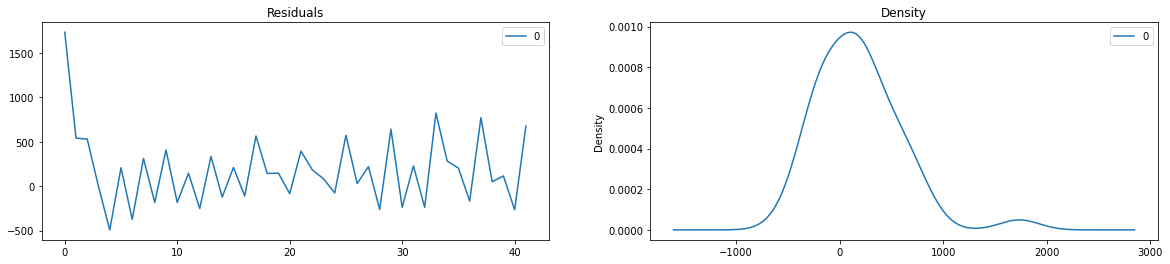

In [33]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0],figsize=(20,4))
residuals.plot(kind="kde", title="Density", ax=ax[1],figsize=(20,4));

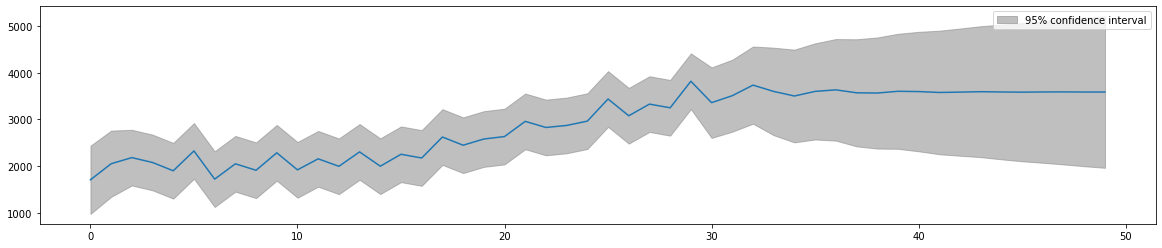

In [34]:
model = sm.tsa.ARIMA(X, order=(2,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=1)[0]
fig, ax = plt.subplots(figsize=(20,4))
a=plot_predict(model_fit,1, 50,ax=ax);

*The above plot is based on ARIMA model with pdq values and forecasted values at 95% confidence level*

## Model Comparision

In [35]:
data={"Model":pd.Series(["Linear","Exponential","Quadratic","Additive seasonality","Additive Seasonality Quadratic",
                         "Multiplicative Seasonality","Multiplicative Additive Seasonality","Simple Exponential Method",
                         "Holt method","Winter with additive seasonality and trend",
                         "Winter with multiplicative seasonality and additive trend","ARIMA"]),
      "RMSE Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,
                               rmse_Mult_add_sea,rmse_ses,rmse_hw,rmse_hwe_aa,rmse_hwe_ma,rmse_arima])}
RMSE = pd.DataFrame(data)
RMSE.sort_values(["RMSE Values"])

,Model,RMSE Values
9,Winter with additive seasonality and trend,245.247579
11,ARIMA,388.609009
6,Multiplicative Additive Seasonality,410.249706
10,Winter with multiplicative seasonality and add...,470.621743
1,Exponential,552.282104
8,Holt method,559.520106
4,Additive Seasonality Quadratic,586.053307
2,Quadratic,646.271543
0,Linear,714.014448
7,Simple Exponential Method,1153.703171


*It can be seen that **Holts winter exponential smoothing with Additive Seasonality and trend** has the least RMSE value **245.247579**.                                                                                                                 
So we further continue and make final model based on it.*

In [36]:
#Holts winter exponential smoothing with additive seasonality and additive trend
cola_final = ExponentialSmoothing(cola1["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() 
pred_cola_final = cola_final.predict(start = cola1.index[0],end = cola1.index[-1])
rmse_cola_final = np.sqrt(np.mean((np.array(cola1["Sales"])-np.array((pred_cola_final)))**2))
mape_cola_final = MAPE(pred_cola_final,cola1.Sales) 
print("RMSE -",round(rmse_cola_final,2),"\nMAPE -  ",round(mape_cola_final,2))

RMSE - 179.72 
MAPE -   5.38


**The Final Model has a RMSE Value of 179.72 & MAPE Value of 5.38**

In [37]:
cola_final.summary()

Dep. Variable:,Sales,No. Observations:,42
Model:,ExponentialSmoothing,SSE,1356560.852
Optimized:,True,AIC,468.077
Trend:,Additive,BIC,495.880
Seasonal:,Additive,AICC,497.816
Seasonal Periods:,12,Date:,"Sat, 26 Nov 2022"
Box-Cox:,False,Time:,15:01:34
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5440643,alpha,True
smoothing_trend,0.0968747,beta,True


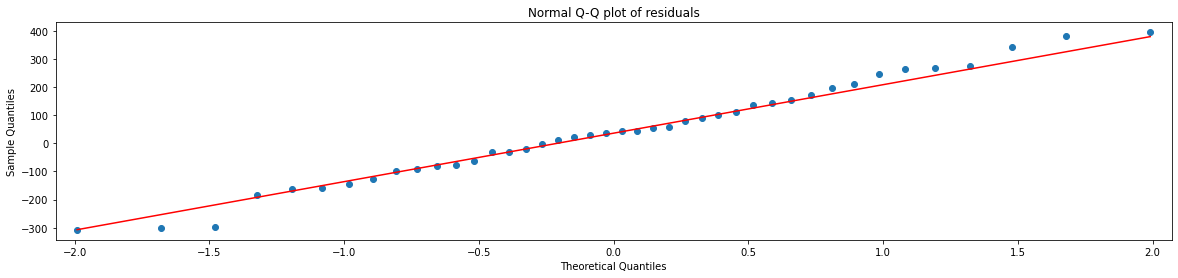

In [38]:
#to plot the errors on line 
fig, ax = plt.subplots(figsize=(20,4))
qqplot=sm.qqplot(cola_final.resid,line="q",ax=ax) 
plt.title("Normal Q-Q plot of residuals")
plt.show();

**The model accuracy and Q-Q Plot shows that the model is good.**